<a href="https://colab.research.google.com/github/sachchit-k/NlpProj/blob/main/IntershipStudioProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import string
import re
import numpy 
from numpy import array,argmax,random,take
import pandas as pd
import keras
from keras.models import Sequential


In [22]:
from keras.layers import Dense,LSTM,Embedding,Bidirectional,RepeatVector,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt


In [23]:
% matplotlib inline
pd.set_option('display.max_colwidth',200)

####function for reading the file of eng-deu sentence pairs

In [24]:
def read_text(filename):
  file=open(filename,mode='rt',encoding='utf-8')
  text=file.read()
  file.close()
  return text

####spliting text into sentences

In [25]:
def to_lines(text):
  sents=text.strip().split('\n')
  sents=[i.split('\t')for i in sents]
  return sents


In [26]:
data=read_text('/content/drive/MyDrive/Proj/1.PROJ/InternshipStudio/deu-eng/deu.txt')
deu_eng=to_lines(data)
deu_eng=array(deu_eng)

In [27]:
deu_eng.shape

(248311, 3)

In [28]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
        'Es ist wohl unmöglich, einen vollkommen fehlerfreien Korpus zu erreichen\xa0— das liegt in der Natur eines solchen Gemeinschaftsprojekts. Doch wenn wir unsere Mitglieder dazu bringen können, nicht mit Sprachen herumzuexperimentieren, die sie gerade lernen, sondern Sätze in ihrer eigenen Muttersprache beizutragen, dann gelingt 

####considering first 50000 sentence pairs only

In [29]:
deu_eng=deu_eng[:50000,:]

In [30]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["Tom isn't my husband.", 'Tom ist nicht mein Ehemann.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5938363 (CK) & #8056099 (Luiaard)'],
       ["Tom isn't my husband.", 'Tom ist nicht mein Ehegatte.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5938363 (CK) & #8056100 (Luiaard)'],
       ["Tom isn't my husband.", 'Tom ist nicht mein Gatte.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5938363 (CK) & #8056101 (Luiaard)']],
      dtype='<U537')

####Text to sequence conversion:

In [31]:
#empty lists
eng_l=[]
deu_l=[]

#populate the lists with sentence lengths
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))


In [ ]:
eng_l,deu_l

In [33]:
length_df=pd.DataFrame({'eng':eng_l,'deu':deu_l})

In [34]:
length_df

,eng,deu
0,1,1
1,1,1
2,1,2
3,1,1
4,1,1
...,...,...
49995,4,5
49996,4,5
49997,4,5
49998,4,5


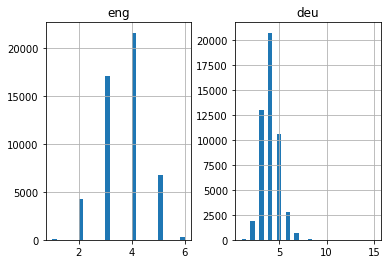

In [35]:
length_df.hist(bins=30)
plt.show()

####Using keras tokenizer sent-->seq of integer
####then we will pad those sequence with zeros to make all the sequcences of same length

In [36]:
#function tp build a tokenizer
def tokenization(lines):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)#fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 
  return tokenizer

In [37]:
#preparing english tokenizer
eng_tokenizer=tokenization(deu_eng[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
eng_length=8

In [43]:
print(eng_tokenizer)

In [38]:
print('English Vocabulary size: %d'% eng_vocab_size)

English Vocabulary size: 6122


In [39]:
#preparing Deutch tokenizer
deu_tokenizer=tokenization(deu_eng[:,1])
deu_vocab_size=len(deu_tokenizer.word_index)+1
deu_length=8
print('Deutch Vocabulary Size: %d' %deu_vocab_size)

Deutch Vocabulary Size: 10076


####function to prepare sequences.also to perform sequence padding

In [44]:
#encoding and pad sequences
def encode_sequences(tokenizer,length,lines):
  #integer encode sequences
  seq=tokenizer.texts_to_sequences(lines)#texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
  #pad sequences with 0 values
  seq=pad_sequences(seq,maxlen=length,padding='post')
  return seq

####model bulding

In [46]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(deu_eng,test_size=0.2,random_state=12)

####encoding and decoding part


In [49]:
#preparing training data
#here we are translating from german to eng hence trainX to be deu_
trainX=encode_sequences(deu_tokenizer,deu_length,train[:,1])
trainY=encode_sequences(eng_tokenizer,eng_length,train[:,0])

In [48]:
#preparing validation data
testX=encode_sequences(deu_tokenizer,deu_length,test[:,1])
testY=encode_sequences(eng_tokenizer,eng_length,test[:,0])

####creating seq to seq model architechtiure
####2 lsmt layer as encoder and decoder

In [50]:
from keras.layers import Embedding, Input
from keras import Model
from tensorflow.keras import optimizers

In [51]:
#built in nmt model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model=Sequential()
  model.add(Embedding(in_vocab,units,input_length=in_timesteps))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units,return_sequences=True))
  model.add(Dense(out_vocab,activation='softmax'))
  return model


####using rmsprop optimizer

In [52]:
model=build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms= optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

# model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
# rms = optimizers.RMSprop(lr=0.001)
# model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [53]:
filename='model.h1.24_sachchit'
checkpoint=ModelCheckpoint(filename,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),
                  epochs=5,batch_size=512,
                  validation_split=0.2,
                  callbacks=[checkpoint],verbose=1)

Epoch 1/5
63/63 [==============================] - ETA: 0s - loss: 3.2037
Epoch 00001: val_loss improved from inf to 2.78730, saving model to model.h1.24_sachchit


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


63/63 [==============================] - 255s 4s/step - loss: 3.2037 - val_loss: 2.7873
Epoch 2/5
63/63 [==============================] - ETA: 0s - loss: 2.7020
Epoch 00002: val_loss improved from 2.78730 to 2.66197, saving model to model.h1.24_sachchit


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


63/63 [==============================] - 252s 4s/step - loss: 2.7020 - val_loss: 2.6620
Epoch 3/5
63/63 [==============================] - ETA: 0s - loss: 2.5675
Epoch 00003: val_loss improved from 2.66197 to 2.57377, saving model to model.h1.24_sachchit


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


63/63 [==============================] - 244s 4s/step - loss: 2.5675 - val_loss: 2.5738
Epoch 4/5
63/63 [==============================] - ETA: 0s - loss: 2.4098
Epoch 00004: val_loss improved from 2.57377 to 2.43624, saving model to model.h1.24_sachchit


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


63/63 [==============================] - 242s 4s/step - loss: 2.4098 - val_loss: 2.4362
Epoch 5/5
63/63 [==============================] - ETA: 0s - loss: 2.2958
Epoch 00005: val_loss improved from 2.43624 to 2.34542, saving model to model.h1.24_sachchit


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


63/63 [==============================] - 242s 4s/step - loss: 2.2958 - val_loss: 2.3454


####Comparing traing loss and validation loss

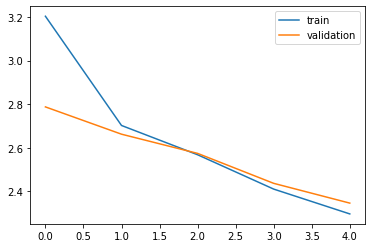

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

####loding the saved model

In [55]:
# import numpy as np
import tensorflow
print(tensorflow.__version__)

2.7.0


In [56]:
model=load_model('/content/drive/MyDrive/Proj/1.PROJ/InternshipStudio/model.h1.24_sachchit')
#https://drive.google.com/drive/folders/1-x61TPTZptvxkFLdbAWvwR5MwUJjORMU?usp=sharing

In [57]:
testX=testX.reshape(testX.shape[0],testX.shape[1])

In [58]:
# preds= (model.predict(testX.reshape((testX.shape[0],testY.shape[0])))).astype("float64")
preds = model.predict(testX).astype("int32")


# predict_x=model.predict(X_test) 
# classes_x=np.argmax(predict_x,axis=1)
# preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [59]:
preds.shape,testX.shape,testY.shape

((10000, 8, 6122), (10000, 8), (10000, 8))

In [60]:
def get_word(n,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==n:
      return word
  return word

In [61]:
#converting prediction into text(English)
 
preds_text=[]
for i in preds:
  temp=[]
  for j in range(len(i)):
      t=get_word(i[j].all(),eng_tokenizer)
      if j>0:
         if (t==get_word(i[j-1].all(),eng_tokenizer))or(t== None):
             temp.append('')
         else:
             temp.append(t)

      else:
         if(t==None):
             temp.append('')
         else:
             temp.append(t)

preds_text.append(' '.join(temp))


In [62]:
preds_text

['designer       ']

In [63]:
len(i),eng_length,deu_length,eng_vocab_size,deu_vocab_size

(8, 8, 8, 6122, 10076)

In [64]:
len(preds_text),len(test)

(1, 10000)

In [71]:
pred_df=pd.DataFrame({'actual':test[:1,0],'predicted':preds_text})

In [72]:
pd.set_option('display.max_colwidth',200)

In [73]:
pred_df.shape

(1, 2)

In [74]:
pred_df.head()

,actual,predicted
0,Tom wasted no time.,designer
